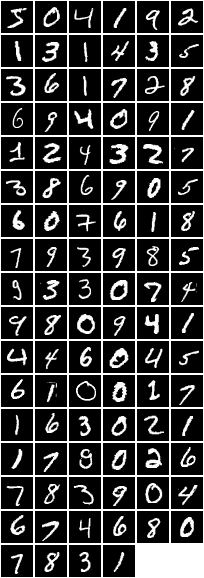

In [9]:
require 'torch'
require 'image'
require 'nn'
-- load data
mnist_raw = torch.load('mnist.t7/train_32x32.t7', 'ascii')
-- some samples
itorch.image(mnist_raw.data[{{1, 100}}])

6	


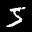

In [26]:
d1 = mnist_raw.data[1]
l1 = mnist_raw.labels[1]
itorch.image(d1)
print(l1)

In [27]:
-- load pre-trained model (trained on the whole dataset size == 60000)
model = torch.load('logs/convnet.net')

In [28]:
-- inspect the model layers
model

nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> (10) -> (11) -> (12) -> output]
  (1): nn.SpatialConvolutionMM(in: 1, out: 6, kW: 5, kH: 5)
  (2): nn.Tanh
  (3): nn.SpatialMaxPooling(kW: 2, kH: 2, dW: 2, dH: 2)
  (4): nn.SpatialConvolutionMap
  (5): nn.Tanh
  (6): nn.SpatialMaxPooling(kW: 2, kH: 2, dW: 2, dH: 2)
  (7): nn.SpatialConvolutionMM(in: 16, out: 120, kW: 5, kH: 5)
  (8): nn.Reshape(120)
  (9): nn.Linear(120 -> 84)
  (10): nn.Tanh
  (11): nn.Linear(84 -> 10)
  (12): nn.LogSoftMax
}
{
  gradInput : FloatTensor - size: 10x1x32x32
  modules : 
    {
      1 : 
        nn.SpatialConvolutionMM(in: 1, out: 6, kW: 5, kH: 5)
        {
          dH : 1
          dW : 1
          nOutputPlane : 6
          output : FloatTensor - size: 10x6x28x28
          gradInput : FloatTensor - size: 10x1x32x32
          finput : FloatTensor - size: 10x25x784
          kW : 5
          kH : 5
          weight : FloatTensor - size: 6x25
          nInputPlane 

          dH : 2
          dW : 2
          kW : 2
          gradInput : FloatTensor - size: 10x6x28x28
          kH : 2
          output : FloatTensor - size: 10x6x14x14
          indices : FloatTensor - size: 2x10x6x14x14
        }
      4 : 
        nn.SpatialConvolutionMap
        {
          dH : 1
          dW : 1
          nInputPlane : 6
          kW : 5
          gradInput : FloatTensor - size: 10x6x14x14
          connTable : FloatTensor - size: 64x2
          weight : FloatTensor - size: 64x5x5
          output : FloatTensor - size: 10x16x10x10
          gradWeight : FloatTensor - size: 64x5x5
          kH : 5
          nOutputPlane : 16
          bias : FloatTensor - size: 16
          gradBias : FloatTensor - size: 16
        }
      5 : 


        nn.Tanh
        {
          gradInput : FloatTensor - size: 10x16x10x10
          output : FloatTensor - size: 10x16x10x10
        }
      6 : 
        nn.SpatialMaxPooling(kW: 2, kH: 2, dW: 2, dH: 2)
        {
          dH : 2
          dW : 2
          kW : 2
          gradInput : FloatTensor - size: 10x16x10x10
          kH : 2
          output : FloatTensor - size: 10x16x5x5
          indices : FloatTensor - size: 2x10x16x5x5
        }
      7 : 
        nn.SpatialConvolutionMM(in: 16, out: 120, kW: 5, kH: 5)
        {
          dH : 1
          dW : 1
          nOutputPlane : 120
          output : FloatTensor - size: 10x120x1x1
          gradInput : FloatTensor - size: 10x16x5x5
          finput : FloatTensor - size: 10x400x1
          kW : 5
          kH : 5
          weight : FloatTensor - size: 120x400
          nInputPlane : 16


          gradWeight : FloatTensor - size: 120x400
          padding : 0
      

    bias : FloatTensor - size: 120
          gradBias : FloatTensor - size: 120
          fgradInput : FloatTensor - size: 10x400x1
        }
      8 : 
        nn.Reshape(120)
        {
          batchsize : LongStorage - size: 2
          size : LongStorage - size: 1
          output : FloatTensor - size: 10x120
          gradInput : FloatTensor - size: 10x120x1x1
          nelement : 120
          _gradOutput : FloatTensor - empty
          _input : FloatTensor - empty
        }
      9 : 
        nn.Linear(120 -> 84)
        {
          gradBias : FloatTensor - size: 84
          weight : FloatTensor - size: 84x120
          bias : FloatTensor - size: 84
          gradInput : FloatTensor - size: 10x120
          output : FloatTensor - size: 10x84
          gradWeight : FloatTensor - size: 84x120
          addBuffer : FloatTensor - size: 10
        }
      10 : 
        nn.Tanh
        {


          gradInput : FloatTensor - size: 10x84
          output : FloatTensor - size: 10x84
        }
      11 : 
        nn.Linear(84 -> 10)
        {
          gradBias : FloatTensor - size: 10
          weight : FloatTensor - size: 10x84
          bias : FloatTensor - size: 10
          gradInput : FloatTensor - size: 10x84
          output : FloatTensor - size: 10x10
          gradWeight : FloatTensor - size: 10x84
          addBuffer : FloatTensor - size: 10
        }
      12 : 
        nn.LogSoftMax
        {
          gradInput : FloatTensor - size: 10x10
          output : FloatTensor - size: 10x10
        }
    }
  output : FloatTensor - size: 10x10
}


In [8]:
require 'optim'
-- this is inferred, i.e. the order
classes = {'0','1','2','3','4','5','6','7','8','9'}
confusion = optim.ConfusionMatrix(classes)
incorrect = {}
function test(dataset, test_model)
   -- local vars
   local model = test_model:clone()
   local time = sys.clock()

   -- test over given dataset
   print('<trainer> on testing Set:')
      -- disp progress
      -- create mini batch
      local inputs = torch.Tensor(10000,1,32,32)
      local targets = torch.Tensor(10000)
      for i = 1, 10000 do
         -- load new sample
         local input = dataset.data[i]:float()
         local target = dataset.labels[i] 
         inputs[i] = input
         targets[i] = target
      end

      local preds = model:forward(inputs:float())
     -- confusion:
     for i = 1, 10000 do
        confusion:add(preds[i], targets[i])
     end

   -- timing
   time = sys.clock() - time
   time = time / 10000
   print("<trainer> time to test 1 sample = " .. (time*1000) .. 'ms')

   -- print confusion matrix
   print(confusion)
end

In [30]:
-- testing without pre-processing, should do normalization
testData = torch.load('mnist.t7/test_32x32.t7', 'ascii')
dataset = testData.data

In [31]:
test(testData, model)

<trainer> on testing Set:	


<trainer> time to test 1 sample = 0.38549139499664ms	


ConfusionMatrix:
[[     965       0       0       0       5       0       2       0       4       4]   98.469% 	[class: 0]
 [       3     487       1       1     226       1       7       0     408       1]   42.907% 	[class: 1]
 [      21       2     843       6      12       0       1       0     147       0]   81.686% 	[class: 2]
 [       2       0       3     893       7      25       0       3      55      22]   88.416% 	[class: 3]
 [       4       0       0       1     958       3       3       0       3      10]   97.556% 	[class: 4]
 [       8       0       0      19       3     785       7       0      55      15]   88.004% 	[class: 5]
 [       9       0       0       1       4       9     918       0      17       0]   95.825% 	[class: 6]
 [      28       3     117      15      76       7       0     322      97     363]   31.323% 	[class: 7]
 [       3       0       2       0       6       1       0       0     958       4]   98.357% 	[class: 8]
 [       4       0       0   

In [8]:
function inferenceAnswer(img)
    model:forward(img)
    prob, target = model:forward(img:float()):max(1)
    target = target:squeeze()
    return target
end
    

In [9]:
d1 = testData.data[1]

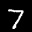

In [10]:
itorch.image(d1)

In [11]:
l1 = testData.labels[1]

In [12]:
l1

8	


In [13]:
inferenceAnswer(d1:float())

8	


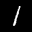

the actual label is (-1)	2	


the inferred label is 	5	


In [14]:
d3 = testData.data[3]
l3 = testData.labels[3]
itorch.image(d3)
print("the actual label is (-1)", l3)
print("the inferred label is ", inferenceAnswer(d3:float()))

In [35]:
-- test the accuracy after normalization
require 'dataset-mnist'
testData = mnist.loadTestSet(10000, {32, 32})
testData:normalizeGlobal()
test(testData, model)

<mnist> done	


<trainer> on testing Set:	


<trainer> time to test 1 sample = 0.99382219314575ms	


ConfusionMatrix:
[[    2919       0       0       0       5       0       3       1       8       4]   99.286% 	[class: 0]
 [      21    2620       7      10     261       3      14       0     468       1]   76.946% 	[class: 1]
 [      57      11    2793      25      16       0       6       4     183       1]   90.213% 	[class: 2]
 [       7       0       9    2855       7      56       1       7      65      23]   94.224% 	[class: 3]
 [       7       0       1       1    2896       3      10       3       6      19]   98.303% 	[class: 4]
 [      12       0       0      34       5    2523      20       3      62      17]   94.283% 	[class: 5]
 [      49       7       2       1       8      24    2765       0      18       0]   96.207% 	[class: 6]
 [      59      12     148      21     119       8       1    2214     106     396]   71.790% 	[class: 7]
 [      10       0       9       4      16      15       6       2    2845      15]   97.365% 	[class: 8]
 [      17       1       2   

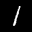

the actual label is (-1)	2	


the inferred label is 	2	


In [16]:
d3 = testData.data[3]
l3 = testData.labels[3]
itorch.image(d3)
print("the actual label is (-1)", l3)
print("the inferred label is ", inferenceAnswer(d3:float()))

the image	


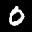

the actual label is 	1	


ConfusionMatrix:
[[       1       0       0       0       0       0       0       0       0       0]   100.000% 	[class: 0]
 [       0       0       0       0       0       0       0       0       0       0]   nan% 	[class: 1]
 [       0       0       0       0       0       0       0       0       0       0]   nan% 	[class: 2]
 [       0       0       0       0       0       0       0       0       0       0]   nan% 	[class: 3]
 [       0       0       0       0       0       0       0       0       0       0]   nan% 	[class: 4]
 [       0       0       0       0       0       0       0       0       0       0]   nan% 	[class: 5]
 [       0       0       0       0       0       0       0       0       0       0]   nan% 	[class: 6]
 [       0       0       0       0       0       0       0       0       0       0]   nan% 	[class: 7]
 [       0       0       0       0       0       0       0       0       0       0]   nan% 	[class: 8]
 [       0       0       0       0       0       0  

  mat : FloatTensor - size: 10x10
  averageUnionValid : 1
  _targ_idx : LongTensor - empty
  averageValid : 1
  classes : 
    {
      1 : 0
      2 : 1


      3 : 2
      4 : 3
      5 : 4
      6 : 5
      7 : 6
      8 : 7
      9 : 8
      10 : 9
    }
  _prediction : FloatTensor - size: 10
  _pred_idx : LongTensor - size: 1
  nclasses : 10
  _max : FloatTensor - size: 1
  _target : FloatTensor - empty
  unionvalids : FloatTensor - size: 10
  totalValid : 1
}


In [17]:
confusion2 = optim.ConfusionMatrix({0, 1, 2, 3, 4, 5, 6, 7, 8, 9})
output = testData.data[4]
print("the image")
itorch.image(output)
l4 = testData.labels[4]
print("the actual label is ", l4)
confusion2:add(model:forward(output:float()), l4)
print(confusion2)

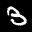

the actual label is, (-1)	3	
the inferred label is, (-1)	5	


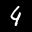

the actual label is, (-1)	4	
the inferred label is, (-1)	9	


the actual label is, (-1)	8	
the inferred label is, (-1)	3	


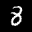

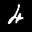

the actual label is, (-1)	4	
the inferred label is, (-1)	6	


the actual label is, (-1)	2	
the inferred label is, (-1)	7	


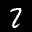

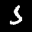

the actual label is, (-1)	5	
the inferred label is, (-1)	3	


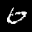

the actual label is, (-1)	6	
the inferred label is, (-1)	0	


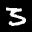

the actual label is, (-1)	3	
the inferred label is, (-1)	5	


the actual label is, (-1)	6	
the inferred label is, (-1)	5	


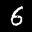

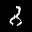

the actual label is, (-1)	8	
the inferred label is, (-1)	2	


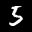

the actual label is, (-1)	5	
the inferred label is, (-1)	3	


the actual label is, (-1)	7	
the inferred label is, (-1)	3	


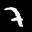

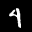

the actual label is, (-1)	4	
the inferred label is, (-1)	9	


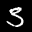

the actual label is, (-1)	3	
the inferred label is, (-1)	5	


the actual label is, (-1)	8	
the inferred label is, (-1)	9	


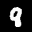

In [18]:
-- inspecting some mismatches
for i = 1, 1000 do
    img = testData.data[i]
    l = testData.labels[i] -1 
    guess = inferenceAnswer(img:float()) -1
    if l ~= guess then
        itorch.image(img)
        print("the actual label is, (-1)", l)
        print("the inferred label is, (-1)", guess)
    end
end

In [19]:
street_view_data = torch.load('Street_View.t7', 'ascii')

In [20]:
street_view_images = street_view_data.X
street_view_labels = street_view_data.y

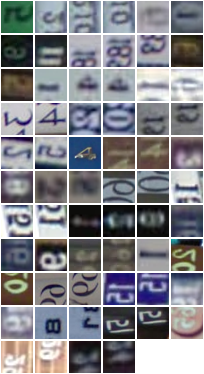

In [21]:
itorch.image(street_view_images[{{1, 64}}])

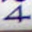

convert rgb to y channel	


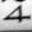

the guess is 	9	


print the whole vector	-1.2888e+01
-1.7471e+01
-1.3733e+01
-1.3893e+01
-8.6277e+00
-7.6607e+00
-8.7658e+00
-1.6337e+01
-8.4822e-04
-1.1376e+01
[torch.FloatTensor of size 10]



In [22]:
street_four = street_view_images[20]
itorch.image(street_four)
-- in y channel
print("convert rgb to y channel")
y_image = image.rgb2y(street_four)
itorch.image(y_image)
guessed_result = inferenceAnswer(y_image:float())
print("the guess is ", guessed_result)
print("print the whole vector", model:forward(y_image:float()))

In [33]:
-- model with ReLU instead of Tanh
model_with_ReLU = torch.load('logs/mnist.net')
print(model_with_ReLU)

nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> (10) -> (11) -> (12) -> output]
  (1): nn.SpatialConvolutionMM(in: 1, out: 6, kW: 5, kH: 5)
  (2): nn.ReLU
  (3): nn.SpatialMaxPooling(kW: 2, kH: 2, dW: 2, dH: 2)
  (4): nn.SpatialConvolutionMap
  (5): nn.ReLU
  (6): nn.SpatialMaxPooling(kW: 2, kH: 2, dW: 2, dH: 2)
  (7): nn.SpatialConvolutionMM(in: 16, out: 120, kW: 5, kH: 5)
  (8): nn.Reshape(120)
  (9): nn.Linear(120 -> 84)
  (10): nn.ReLU
  (11): nn.Linear(84 -> 10)
  (12): nn.LogSoftMax
}
{
  gradInput : FloatTensor - size: 10x1x32x32
  modules : 
    {
      1 : 
        nn.SpatialConvolutionMM(in: 1, out: 6, kW: 5, kH: 5)
        {
          dH : 1
          dW : 1
          nOutputPlane : 6
          output : FloatTensor - size: 10x6x28x28
          gradInput : FloatTensor - size: 10x1x32x32
         

 finput : FloatTensor - size: 10x25x784
          kW : 5
          kH : 5
          weight : FloatTensor - size: 6x25
          nInputPlane : 1
          gradWeight : FloatTensor - size: 6x25
          padding : 0
          bias : FloatTensor - size: 6
          gradBias : FloatTensor - size: 6
          fgradInput : FloatTensor - size: 10x25x784
        }
      2 : 
        nn.ReLU
        {
          inplace : false
          threshold : 0
          val : 0
          output : FloatTensor - size: 10x6x28x28
          gradInput : FloatTensor - size: 10x6x28x28
        }
      3 : 
        nn.SpatialMaxPooling(kW: 2, kH: 2, dW: 2, dH: 2)
        {
         

 dH : 2
          dW : 2
          kW : 2
          gradInput : FloatTensor - size: 10x6x28x28
          kH : 2
          output : FloatTensor - size: 10x6x14x14
          indices : FloatTensor - size: 2x10x6x14x14
        }
      4 : 
        nn.SpatialConvolutionMap
        {
          dH : 1
          dW : 1
          nInputPlane : 6
          kW : 5
          gradInput : FloatTensor - size: 10x6x14x14
          connTable : FloatTensor - size: 64x2
          weight : FloatTensor - size: 64x5x5
          output : FloatTensor - size: 10x16x10x10
          gradWeight : FloatTensor - size: 64x5x5
          kH : 5
          nOutputPlane : 16
          bias : FloatTensor - size: 16
          gradBias : FloatTensor - size: 16
       

 }
      5 : 
        nn.ReLU
        {
          inplace : false
          threshold : 0
          val : 0
          output : FloatTensor - size: 10x16x10x10
          gradInput : FloatTensor - size: 10x16x10x10
        }
      6 : 
        nn.SpatialMaxPooling(kW: 2, kH: 2, dW: 2, dH: 2)
        {
          dH : 2
          dW : 2
          kW : 2
          gradInput : FloatTensor - size: 10x16x10x10
          kH : 2
          output : FloatTensor - size: 10x16x5x5
          indices : FloatTensor - size: 2x10x16x5x5
        }
      7 : 
        nn.SpatialConvolutionMM(in: 16, out: 120, kW: 5, kH: 5)
        {
          dH : 1
          dW : 1
          nOutputPlane : 120
          output : FloatTensor - size: 10x120x1x1
          gradInput : FloatTensor - size: 10x16x5x5


          finput : FloatTensor - size: 10x400x1
          kW : 5
          kH : 5
          weight : FloatTensor - size: 120x400
          nInputPlane : 16
          gradWeight : FloatTensor - size: 120x400
          padding : 0
          bias : FloatTensor - size: 120
          gradBias : FloatTensor - size: 120
          fgradInput : FloatTensor - size: 10x400x1
        }
      8 : 
        nn.Reshape(120)
        {
          batchsize : LongStorage - size: 2
          size : LongStorage - size: 1
          output : FloatTensor - size: 10x120
          gradInput : FloatTensor - size: 10x120x1x1
          nelement : 120
          _gradOutput : FloatTensor - empty
          _input : FloatTensor - empty
        }
      9 : 
        

nn.Linear(120 -> 84)
        {
          gradBias : FloatTensor - size: 84
          weight : FloatTensor - size: 84x120
          bias : FloatTensor - size: 84
          gradInput : FloatTensor - size: 10x120
          output : FloatTensor - size: 10x84
          gradWeight : FloatTensor - size: 84x120
          addBuffer : FloatTensor - size: 10
        }
      10 : 
        nn.ReLU
        {
          inplace : false
          threshold : 0
          val : 0
          output : FloatTensor - size: 10x84
          gradInput : FloatTensor - size: 10x84
        }
      11 : 
        nn.Linear(84 -> 10)
        {
          gradBias : FloatTensor - size: 10
          weight : FloatTensor - size: 10x84
       

   bias : FloatTensor - size: 10
          gradInput : FloatTensor - size: 10x84
          output : FloatTensor - size: 10x10
          gradWeight : FloatTensor - size: 10x84
          addBuffer : FloatTensor - size: 10
        }
      12 : 
        nn.LogSoftMax
        {
          gradInput : FloatTensor - size: 10x10
          output : FloatTensor - size: 10x10
        }
    }
  output : FloatTensor - size: 10x10
}


In [36]:
test(testData, model_with_ReLU)

<trainer> on testing Set:	


<trainer> time to test 1 sample = 5.4454166173935ms	


ConfusionMatrix:
[[    3895       0       0       0       5       0       3       1      11       5]   99.362% 	[class: 0]
 [      26    3737       8      12     264       5      15       1     471       1]   82.313% 	[class: 1]
 [      76      12    3788      29      16       0       7       6     193       1]   91.764% 	[class: 2]
 [       8       0      13    3847       7      65       1       8      68      23]   95.223% 	[class: 3]
 [       7       0       1       2    3870       3      13       3       6      23]   98.523% 	[class: 4]
 [      14       0       0      39       5    3401      22       5      63      19]   95.320% 	[class: 5]
 [      61       9       2       3      10      26    3703       0      18       0]   96.634% 	[class: 6]
 [      65      18     155      25     120       8       1    3202     107     411]   77.870% 	[class: 7]
 [      18       0      12       6      19      29       8       2    3785      17]   97.151% 	[class: 8]
 [      23       3       3   

In [11]:
require 'nn'
model = torch.load('logs/mnist.net')
print(model)

nn.Sequential {
  [input -> (1) -> (2) -> (3) -> output]
  (1): nn.Reshape(1024)
  (2): nn.Linear(1024 -> 10)
  (3): nn.LogSoftMax
}
{
  gradInput : FloatTensor - size: 10x1x32x32
  modules : 
    {
      1 : 
        nn.Reshape(1024)
        {
          batchsize : LongStorage - size: 2
          size : LongStorage - size: 1
          output : FloatTensor - size: 10x1024
  

        gradInput : FloatTensor - size: 10x1x32x32
          nelement : 1024
          _gradOutput : FloatTensor - empty
          _input : FloatTensor - empty
        }
      2 : 
        nn.Linear(1024 -> 10)
        {
          gradBias : FloatTensor - size: 10
          weight : FloatTensor - size: 10x1024
          bias : FloatTensor - size: 10
          gradInput : FloatTensor - size: 10x1024
          output : FloatTensor - size: 10x10
          gradWeight : FloatTensor - size: 10x1024
          addBuffer : FloatTensor - size: 10
        }
      3 : 
        nn.LogSoftMax
        {
          gradInput : FloatTensor - size: 10x10
          output : FloatTensor - size: 10x10
        }
    }
  output : FloatTensor - size: 10x10
}


In [12]:
require 'dataset-mnist'
testData = mnist.loadTestSet(10000, {32, 32})
testData:normalizeGlobal()
test(testData, model)

<mnist> done	


<trainer> on testing Set:	


<trainer> time to test 1 sample = 0.041956281661987ms	


ConfusionMatrix:
[[     968       0       0       1       1       4       3       2       1       0]   98.776% 	[class: 0]
 [       0    1120       1       4       1       2       4       1       2       0]   98.678% 	[class: 1]
 [      14      48     740     158       5      13      17       3      24      10]   71.705% 	[class: 2]
 [       8       2      11     927       1      32       2      10       9       8]   91.782% 	[class: 3]
 [       2       1       5       1     869       0      12       0      14      78]   88.493% 	[class: 4]
 [      14       1       1      43      18     767      10       4      26       8]   85.987% 	[class: 5]
 [      18       5       5       1       6      34     886       2       1       0]   92.484% 	[class: 6]
 [       4      14      20      24      11       3       0     859       8      85]   83.560% 	[class: 7]
 [      12      33       6     172      26      44      10       4     636      31]   65.298% 	[class: 8]
 [       9       8       1   